# States for MDP 

States from paper

http://www.ijmlc.org/vol5/515-C003.pdf

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result
from lob_data_utils.svm_calculation import lob_svm
import states

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stock = '9061'

In [3]:
df, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', length=data_length)
df.drop(columns=['bid', 'ask'], inplace=True)

In [4]:
print(len(df))
df.head()

8000


,Unnamed: 0,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2000,2013-09-10 09:41:00,708.6,708.8,708.70,1468.0,5247.0,0.0,0.562770
2001,2013-09-10 09:43:00,707.5,707.8,707.65,10184.0,3318.0,0.0,-0.508517
2002,2013-09-10 09:44:00,707.4,707.5,707.45,760.0,4063.0,0.0,0.684843
2003,2013-09-10 09:45:00,707.1,707.3,707.20,4029.0,6229.0,1.0,0.214467
2004,2013-09-10 09:46:00,707.3,707.5,707.40,4508.0,9404.0,0.0,0.351926


## Introduce states

    state will be bid_price, ask_price, spread, sum_sell_ask, sum_buy_bid, mid_price
    queue imbalance
    TODO: spread does not seem to have any sense!

In [5]:
df = states.add_state(df)
df.head()

,Unnamed: 0,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,spread,state_ask,state_bid,state_sum_ask,state_sum_bid,state_spread,state_imbalance,state_mid
2000,2013-09-10 09:41:00,708.6,708.8,708.70,1468.0,5247.0,0.0,0.562770,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,2013-09-10 09:43:00,707.5,707.8,707.65,10184.0,3318.0,0.0,-0.508517,0.3,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
2002,2013-09-10 09:44:00,707.4,707.5,707.45,760.0,4063.0,0.0,0.684843,0.1,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0
2003,2013-09-10 09:45:00,707.1,707.3,707.20,4029.0,6229.0,1.0,0.214467,0.2,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0
2004,2013-09-10 09:46:00,707.3,707.5,707.40,4508.0,9404.0,0.0,0.351926,0.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Clustering states attempt

In [6]:
df.dropna(inplace=True)
state_labels = [c for c in df.columns if 'state' in c]
dbscan = cluster.DBSCAN()
groups = dbscan.fit_predict(df[state_labels])
df['groups'] = groups

In [7]:
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual, widgets


@interact(num=(-1, len(np.unique(dbscan.labels_)) - 1))
def _plot_lob(num):
    py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

    data = []
    for i in state_labels:
        data.append(go.Scatter(
            x=df.index, # assign x as the dataframe column 'x'
            y=df[df['groups'] == num][i], name=i, opacity=0.25))
    title='df {}'.format(len(df[df['groups'] == num]))
    layout = go.Layout(
            title = title,
            showlegend = True,
            legend = dict(orientation="h")
        )

    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure, filename='pandas/basic-line-plot', config=py_config)

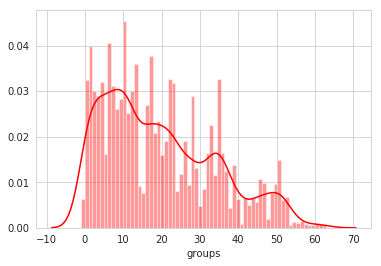

In [8]:
sns.distplot(df['groups'], bins=len(df['groups'].unique()), color='r')

## Let's hash the states



In [9]:
hashes = []
for i, row in df.iterrows():
    hashes.append(states.get_state_number(df, i))
df['hash'] = hashes

In [10]:
df['hash'].head(20)

2001     648
2002    1476
2003    2106
2004    2186
2005       0
2006    2107
2007    1638
2008       0
2009      80
2010     629
2011    1700
2012     710
2013     567
2014    1557
2015    1476
2016     548
2017    2106
2018    1476
2019    1697
2020    2087
Name: hash, dtype: int64

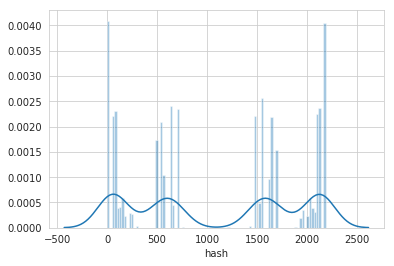

In [11]:
sns.distplot(df['hash'], bins=len(df['hash'].unique()))

In [12]:
df['hash'].unique()

array([ 648, 1476, 2106, 2186,    0, 2107, 1638,   80,  629, 1700,  710,
        567, 1557,  548, 1697, 2087,   18, 2124,   61, 1619,   79, 2125,
       2168,   62, 2105, 1537, 2165,   99,  486,  489,  180,   81, 2183,
         21,  707, 1538,    3, 1639, 1944, 1479,  162, 2126, 1962, 2006,
        224, 2024,  649,  143, 2023,  161, 2043,  547,  242, 2025,  243,
         78, 1965,  221, 2180,  163, 1943, 2108,   60,  747, 1947, 1536,
        304, 2162,   24, 1436,    6,  246,  828,  181, 2005, 1482,  546,
       1640, 1215, 1358,  650,  467, 1694,  909, 1439, 1882,  750, 1277,
       1800,  968, 1862])

In [13]:
transitions = np.zeros((max(df['hash'])+1, max(df['hash'] + 1)))
previous_row = None
for i, row in df.iterrows():
    if not np.any(previous_row):
        previous_row = row
        continue
    transitions[row['hash']][previous_row['hash']] += 1
    previous_row = row
    

for j in range(len(transitions)):
    s = np.sum(transitions[j])
    if s == 0:
        continue
    for i in range(len(transitions[j])):
        transitions[j][i] = transitions[j][i]/s

transitions[547][181]

0.008547008547008548

In [14]:
for j in range(len(transitions)):
    for i in range(len(transitions[i])):
        if transitions[j][i] > 0.5:
            print(j, i, transitions[j][i])

163 547 0.6666666666666666
246 1638 1.0
467 3 1.0
546 1557 1.0
650 2087 1.0
747 567 1.0
828 710 1.0
909 1476 1.0
968 750 1.0
1277 489 1.0
1358 242 1.0
1439 143 1.0
1694 62 1.0
1800 21 1.0
1862 143 1.0


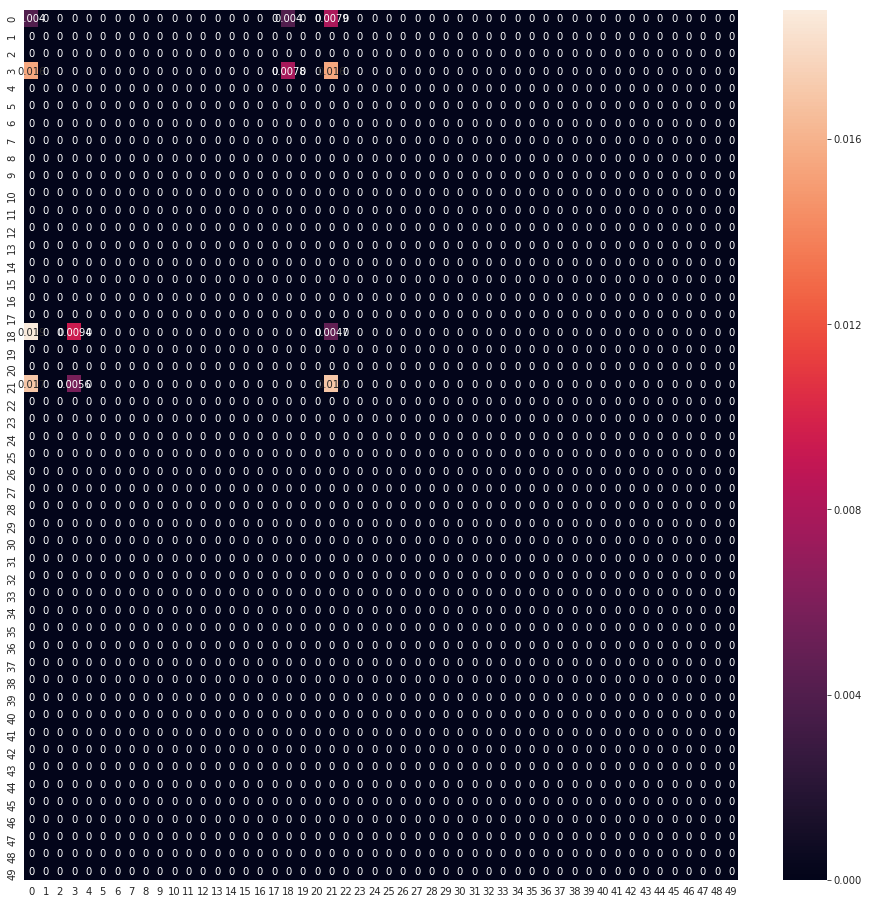

In [15]:
temp = np.zeros((50, 50))
for i in range(len(temp)):
    for j in range(len(temp[i])):
        temp[i][j] = transitions[i][j]
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(temp, annot=True, ax=ax)

In [16]:
for j in range(len(transitions)):
    if np.sum(transitions[j]) < 1 and j in df['hash'].values:
        print(j, np.sum(transitions[j]))


0 0.9999999999999998
6 0.9999999999999998
81 0.9999999999999998
143 0.9999999999999999
181 0.9999999999999999
629 0.9999999999999999
1638 0.9999999999999999


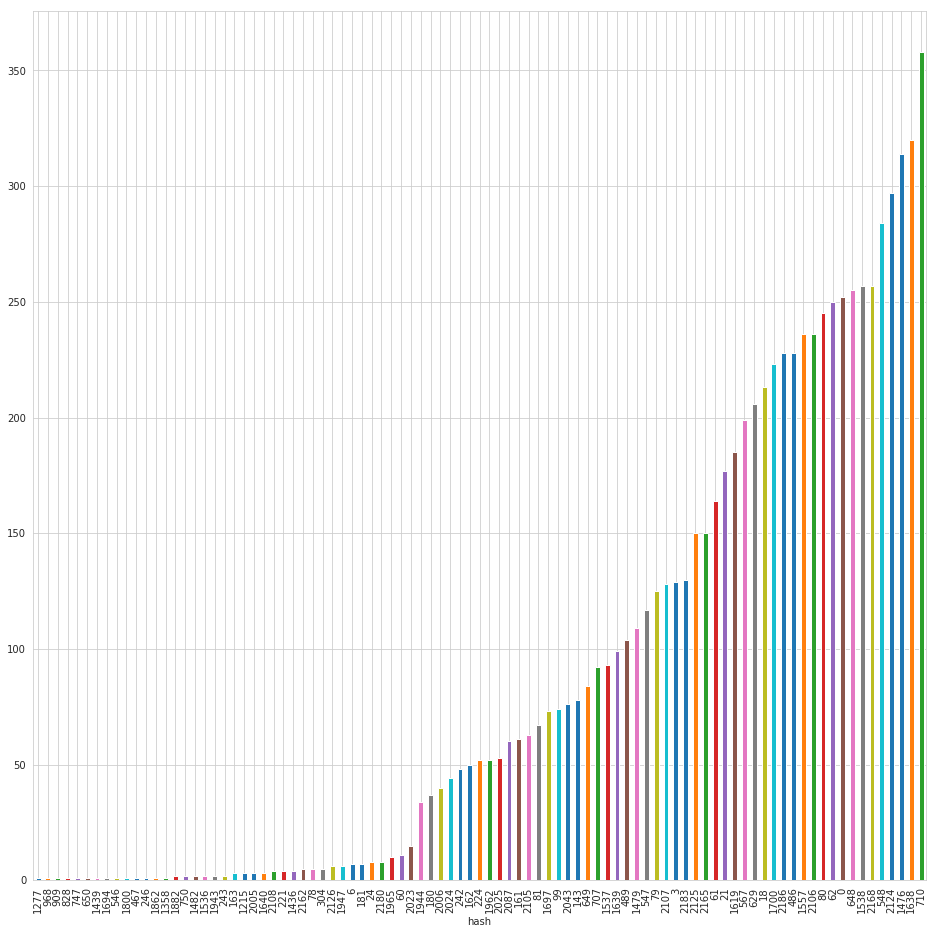

In [17]:
df.groupby(by='hash')['hash'].count().sort_values().plot(kind='bar', figsize=(16, 16))

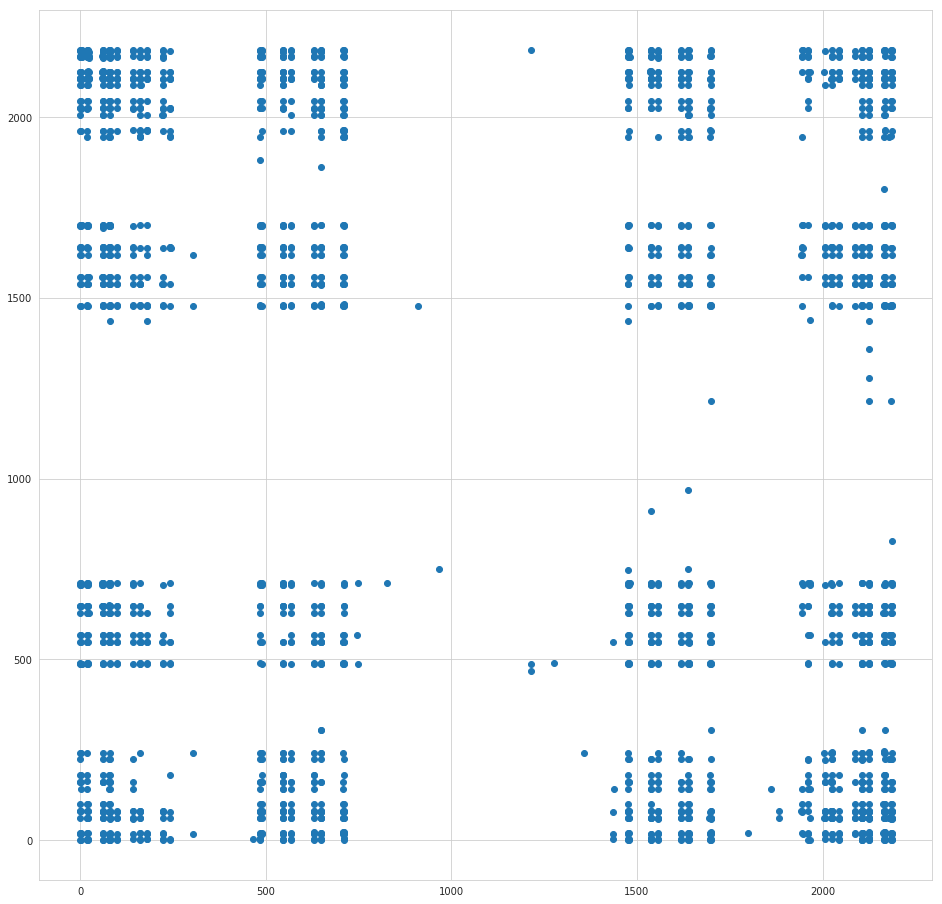

In [18]:
x = []
y = []
for i in range(len(transitions)):
    for j in range(len(transitions)):
        if transitions[i][j] > 0:
            x.append(i)
            y.append(j)
            
plt.figure(figsize=(16,16))
plt.scatter(x, y)

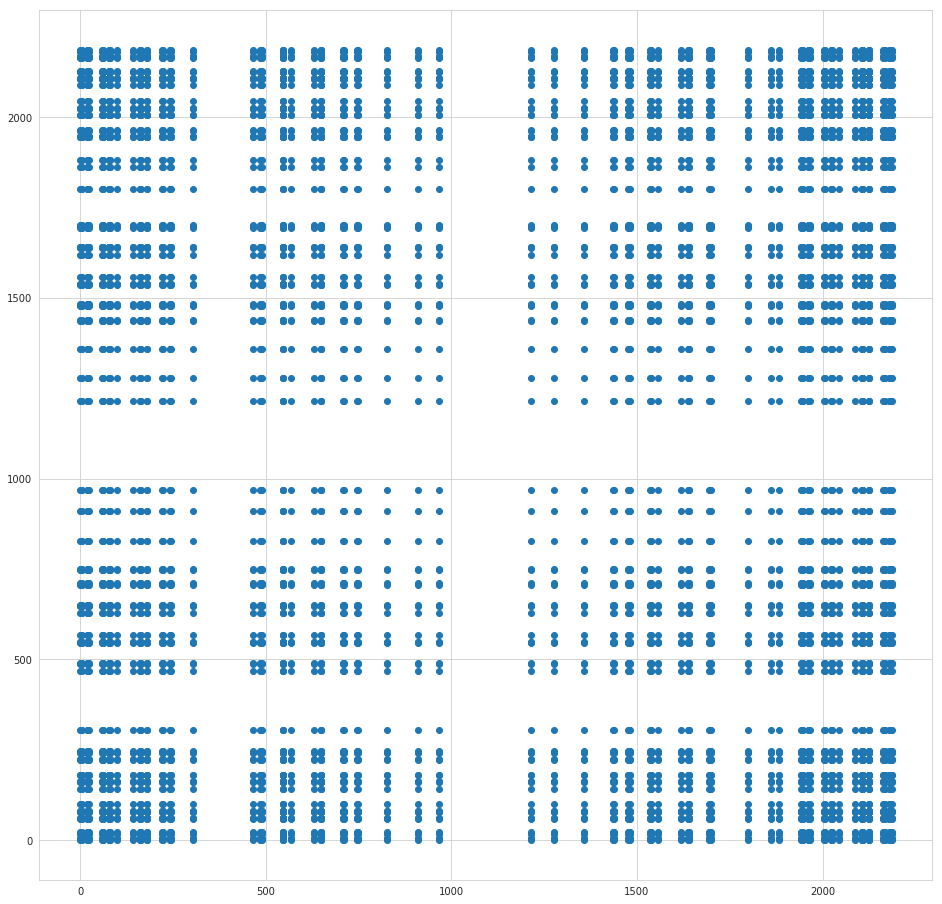

In [19]:
def plot_matrix(m2):
    x = []
    y = []
    for i in range(len(m2.A)):
        for j in range(len(m2.A)):
            if m2.A[i][j] > 0:
                x.append(i)
                y.append(j)

    plt.figure(figsize=(16,16))
    plt.scatter(x, y)

m = np.matrix(transitions)
m2 = m ** 100
plot_matrix(m2)

In [20]:
df.head()

,Unnamed: 0,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,spread,state_ask,state_bid,state_sum_ask,state_sum_bid,state_spread,state_imbalance,state_mid,groups,hash
2001,2013-09-10 09:43:00,707.5,707.8,707.65,10184.0,3318.0,0.0,-0.508517,0.3,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,0,648
2002,2013-09-10 09:44:00,707.4,707.5,707.45,760.0,4063.0,0.0,0.684843,0.1,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1,1476
2003,2013-09-10 09:45:00,707.1,707.3,707.20,4029.0,6229.0,1.0,0.214467,0.2,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,2,2106
2004,2013-09-10 09:46:00,707.3,707.5,707.40,4508.0,9404.0,0.0,0.351926,0.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3,2186
2005,2013-09-10 09:47:00,706.9,707.0,706.95,1494.0,2598.0,0.0,0.269795,0.1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4,0


In [21]:
np.argmax(transitions[181])

1965

In [22]:
df[list(sorted([c for c in df.columns if 'state' in c]))].head(2)

,state_ask,state_bid,state_imbalance,state_mid,state_spread,state_sum_ask,state_sum_bid
2001,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0
2002,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0


In [23]:
states.unhash_state(181, sorted([c for c in df.columns if 'state' in c]))

{'state_ask': 0,
 'state_bid': -1,
 'state_imbalance': 1,
 'state_mid': -1,
 'state_spread': 1,
 'state_sum_ask': -1,
 'state_sum_bid': -1}

## Accessibility of states

P - transition matrix

State j is said to be accessible from state i if $P_{ij}^n > 0$ for some $n >= 0$.
Two states i and j that are accessible to each other are said to communicate.

In [24]:
def if_states_communicating(transitions, state1, state2, n=1):
    if n == 1:
        return transitions[state1][state2] > 0 and transitions[state2][state1] > 0
    temp = transitions
    for i in range(n):
        if temp[state1][state2] > 0 and temp[state2][state1] > 0:
            return True
        temp = np.matmul(temp, temp)
    return False

if_states_communicating(transitions, 181, 547, n=1)

False

In [32]:
def get_state_groups(transitions):
    groups = [[i] for i in list(range(len(transitions)))]
    for i in range(len(transitions)):
        for j in range(i+1, len(transitions)):
            if if_states_communicating(transitions, i, j):
                groups[i].append(j)
    return groups
        
groups = get_state_groups(transitions)

(2132, 55)

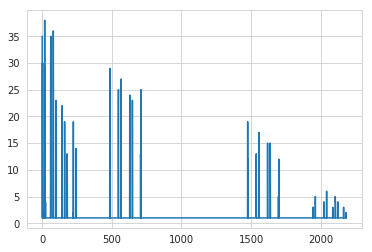

In [34]:
def get_group_lengths(groups, plot=False):
    groups_lengths = [len(g) for g in groups]
    if plot:
        plt.plot(groups_lengths)
    empty_groups = 0
    for i in range(len(groups_lengths)):
        if groups_lengths[i] <= 1:
            empty_groups += 1
    return empty_groups, len(groups_lengths) - empty_groups

get_group_lengths(groups, plot=True)

In [35]:
## Analyze groups
for g in groups:
    if len(g) > 1:
        print(g)

[0, 18, 21, 62, 80, 81, 99, 162, 224, 242, 486, 548, 567, 629, 648, 710, 1476, 1538, 1557, 1619, 1638, 1639, 1697, 1700, 1962, 2043, 2105, 2106, 2107, 2124, 2125, 2165, 2168, 2183, 2186]
[3, 18, 21, 80, 143, 180, 242, 486, 548, 567, 648, 649, 1476, 1538, 1557, 1619, 1638, 1639, 1697, 1700, 2024, 2043, 2105, 2106, 2124, 2125, 2165, 2168, 2183, 2186]
[6, 486]
[18, 61, 62, 80, 99, 143, 180, 486, 489, 547, 548, 567, 629, 648, 649, 707, 710, 1476, 1537, 1538, 1557, 1638, 1639, 1697, 1700, 1962, 2024, 2043, 2087, 2105, 2106, 2107, 2124, 2125, 2165, 2168, 2183, 2186]
[21, 62, 81, 486, 489, 548, 567, 629, 648, 649, 707, 710, 1476, 1557, 1619, 1638, 1697, 1700, 2043, 2087, 2106, 2107, 2108, 2124, 2125, 2165, 2168, 2183, 2186]
[24, 629, 2124, 2168]
[60, 1557]
[61, 99, 242, 486, 567, 648, 649, 707, 710, 1476, 1479, 1538, 1557, 1619, 1638, 1639, 1697, 1700, 2005, 2006, 2025, 2043, 2107, 2124, 2125, 2126, 2165, 2168, 2180, 2183, 2186]
[62, 80, 81, 99, 161, 486, 548, 567, 629, 648, 649, 710, 1476, 1

In [43]:
print(if_states_communicating(transitions, 61, 62))
print(if_states_communicating(transitions, 61, 99))
print(if_states_communicating(transitions, 62, 99))
print(transitions[61][62], transitions[62][61], transitions[61][99], transitions[62][99], transitions[99][61], 
     transitions[99][61])

False
True
True
0.0 0.004 0.012195121951219513 0.004 0.013513513513513514 0.013513513513513514


In [27]:
def plot_heatmap(transitions, plot_name='transitions.png'):
    hashes = df['hash'].unique()
    transition_states_only = []

    for i in range(len(hashes)):
        for j in range(len(hashes)):
            transition_states_only.append({'i': i, 'j': j, 'val': transitions[hashes[i]][hashes[j]]})
    
    fig, ax = plt.subplots(figsize=(64, 64))
    df_trans = pd.DataFrame(transition_states_only)
    df_trans = df_trans.pivot('i', 'j', 'val')
    sns.heatmap(df_trans, annot=True, ax=ax)
    plt.savefig(plot_name)
    return df_trans

In [30]:
temp = np.matmul(transitions, transitions)
for i in range(2, 10):
    groups2 = get_state_groups(temp)
    g = get_group_lengths(groups2)
    temp = np.matmul(temp, transitions)
plot_heatmap(temp, plot_name='plots/transitions_{}_{}.png'.format(stock, i))
plt.title('{} {}'.format(i, g))
get_group_lengths(groups2, plot=True)



(2096, 91)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [31]:
len(df['hash'].unique())
groups_clusters = [i for i in range(len(groups2)) if len(groups2[i]) == 127]
print(len(groups_clusters), len(set(df['hash'].unique())))
set(df['hash'].unique()) - set(groups_clusters)

0 91


{0,
 3,
 6,
 18,
 21,
 24,
 60,
 61,
 62,
 78,
 79,
 80,
 81,
 99,
 143,
 161,
 162,
 163,
 180,
 181,
 221,
 224,
 242,
 243,
 246,
 304,
 467,
 486,
 489,
 546,
 547,
 548,
 567,
 629,
 648,
 649,
 650,
 707,
 710,
 747,
 750,
 828,
 909,
 968,
 1215,
 1277,
 1358,
 1436,
 1439,
 1476,
 1479,
 1482,
 1536,
 1537,
 1538,
 1557,
 1619,
 1638,
 1639,
 1640,
 1694,
 1697,
 1700,
 1800,
 1862,
 1882,
 1943,
 1944,
 1947,
 1962,
 1965,
 2005,
 2006,
 2023,
 2024,
 2025,
 2043,
 2087,
 2105,
 2106,
 2107,
 2108,
 2124,
 2125,
 2126,
 2162,
 2165,
 2168,
 2180,
 2183,
 2186}